In [1]:
# Reload patched module so changes take effect
import importlib
from privacygan import privacy_gan as pg
importlib.reload(pg)
print('privacy_gan reloaded')

/data/miniconda/envs/privGAN/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


privacy_gan reloaded


In [2]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import warnings
from privacygan import privacy_gan as pg
from privacygan.lfw import lfw_gan
from datetime import datetime
from sklearn.datasets import fetch_lfw_people

warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__, "device:", device)


2.4.1+cu124 device: cuda


### Load dataset

In [3]:
# Load LFW dataset via sklearn and build train/test splits
try:
	# Try to fetch/cached LFW dataset (may fail if internet is blocked)
	lfw = fetch_lfw_people(min_faces_per_person=20, resize=0.5)
	X_all = lfw.data.astype(np.float32)
	# Normalize pixel values to [-1, 1]
	X_all = (X_all - 127.5) / 127.5
except Exception as e:
	# Fall back to a synthetic placeholder dataset with the same shape (62x47) to keep the notebook runnable
	print(f"Warning: failed to fetch LFW dataset ({e}). Using a synthetic placeholder dataset instead.")
	rng = np.random.default_rng(42)
	n_samples = 1000
	# Each image flattened to 62*47 to match LFW resized shape
	X_all = rng.normal(0.0, 1.0, size=(n_samples, 62 * 47)).astype(np.float32)
	# Scale to [-1, 1]
	X_min, X_max = X_all.min(), X_all.max()
	X_all = 2.0 * (X_all - X_min) / (X_max - X_min) - 1.0

frac = 0.1
n = int(frac * len(X_all))
idx = np.random.permutation(len(X_all))
X = X_all[idx[:n]]
X_comp = X_all[idx[n:]]

print('training set size:', X.shape)
print('test set size:', X_comp.shape)


training set size: (100, 2914)
test set size: (900, 2914)


### Simple GAN

In [4]:
(generator, discriminator, dLosses, gLosses) = pg.SimpGAN(
    X,
    generator=lfw_gan.LFW_Generator(),
    discriminator=lfw_gan.LFW_Discriminator(),
    epochs=1,
    batchSize=128,
)


Epochs: 1
Batch size: 128
Batches per epoch: 0
epoch = 1/1, d_loss=nan, g_loss=nan


In [5]:
#perform white box attack
Acc = pg.WBattack(X,X_comp, discriminator)

White-box attack accuracy: 0.13


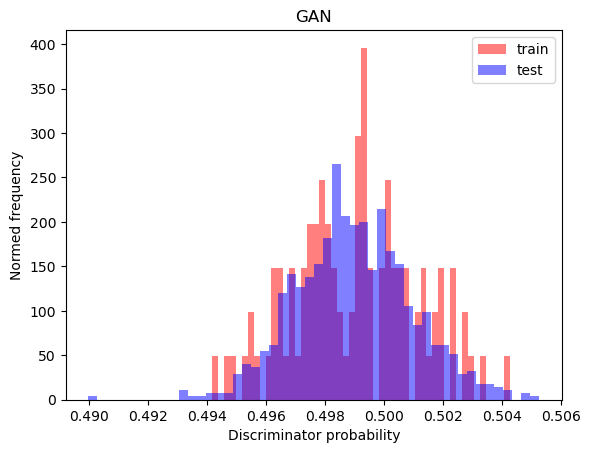

In [6]:
with torch.no_grad():
    scores_train = discriminator(torch.tensor(X, dtype=torch.float32, device=device)).cpu().numpy().squeeze()
    scores_test = discriminator(torch.tensor(X_comp, dtype=torch.float32, device=device)).cpu().numpy().squeeze()

plt.hist(scores_train, color='r', alpha=0.5, label='train', density=True, bins=50)
plt.hist(scores_test, color='b', alpha=0.5, label='test', density=True, bins=50)
plt.xlabel('Discriminator probability')
plt.ylabel('Normed frequency')
plt.title('GAN')
plt.legend()


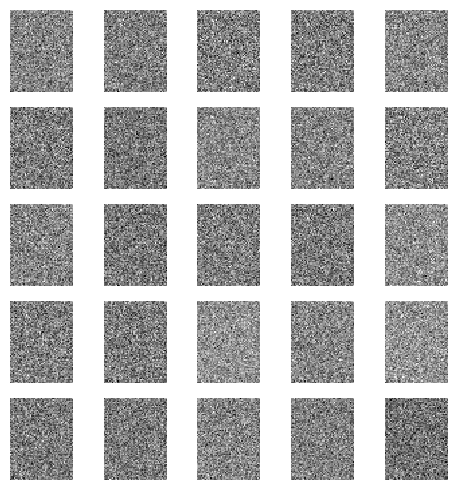

In [7]:
#generate synthetic images
noise = np.random.normal(0, 1, size=[X.shape[0], 100])
noise_t = torch.tensor(noise, dtype=torch.float32, device=device)
generatedImages = generator(noise_t).detach().cpu().numpy()
temp = generatedImages[:25].reshape(25, 62, 47)
plt.figure(figsize=(5, 5))
for i in range(temp.shape[0]):
    plt.subplot(5,5, i+1)
    plt.imshow(temp[i], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()

### Private GAN

In [8]:
### Test privGAN (with n_reps = 2)
generators = [lfw_gan.LFW_Generator(), lfw_gan.LFW_Generator()]
discriminators = [lfw_gan.LFW_Discriminator(), lfw_gan.LFW_Discriminator()]
pDisc = lfw_gan.LFW_DiscriminatorPrivate(OutSize=2)

(generators, discriminators, _, dLosses, dpLosses, gLosses) = pg.privGAN(
    X,
    epochs=1,
    disc_epochs=1,
    batchSize=128,
    generators=generators,
    discriminators=discriminators,
    pDisc=pDisc,
    privacy_ratio=1.0,
)


dp-Accuracy: 0.42
Epochs: 1
Batch size: 128
Batches per epoch: 1
epoch = 0/1, batch = 1/1
dLosses = [1.38139939 1.39242005]
dpLosses = 0.0
gLosses = 2.772072672843933
dp-Accuracy: 0.3984375


In [9]:
#perform white box attack
pg.WBattack_priv(X,X_comp, discriminators)

White-box attack accuracy (max): 0.42
White-box attack accuracy (mean): 0.5


(0.42, 0.5)

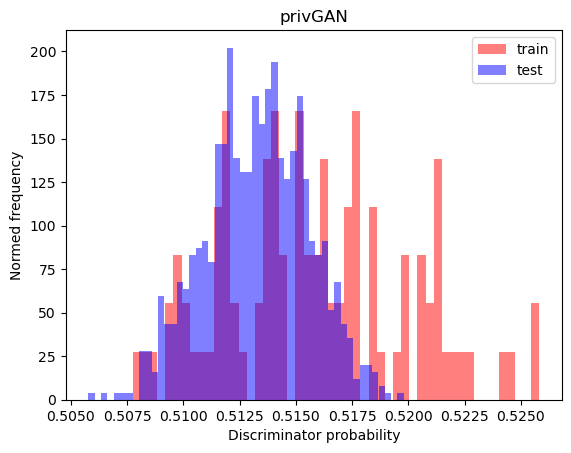

In [10]:
with torch.no_grad():
    scores_train = discriminators[0](torch.tensor(X, dtype=torch.float32, device=device)).cpu().numpy().squeeze()
    scores_test = discriminators[0](torch.tensor(X_comp, dtype=torch.float32, device=device)).cpu().numpy().squeeze()

plt.hist(scores_train, color='r', alpha=0.5, label='train', density=True, bins=50)
plt.hist(scores_test, color='b', alpha=0.5, label='test', density=True, bins=50)
plt.xlabel('Discriminator probability')
plt.ylabel('Normed frequency')
plt.title('privGAN')
plt.legend()


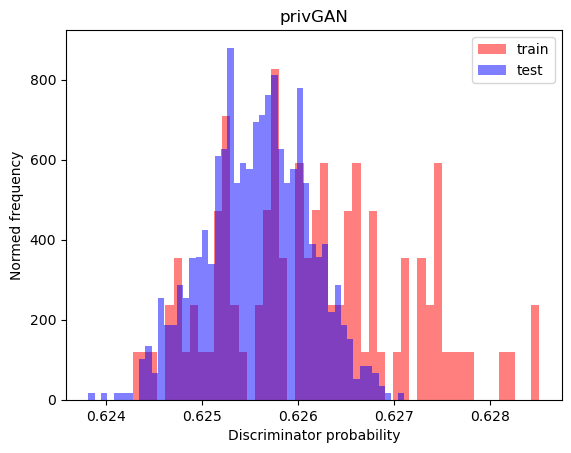

In [13]:
#plot distribution of discriminator scores of training and test set
with torch.no_grad():
    x_tr = torch.tensor(X, dtype=torch.float32, device=device)
    x_te = torch.tensor(X_comp, dtype=torch.float32, device=device)
    out_tr = discriminators[0](x_tr)
    out_te = discriminators[0](x_te)
    try:
        probs_tr = torch.sigmoid(out_tr).detach().cpu().numpy().squeeze()
        probs_te = torch.sigmoid(out_te).detach().cpu().numpy().squeeze()
    except Exception:
        probs_tr = out_tr.detach().cpu().numpy().squeeze()
        probs_te = out_te.detach().cpu().numpy().squeeze()

plt.hist(probs_tr, color='r', alpha=0.5, label='train', density=True, bins=50)
plt.hist(probs_te, color='b', alpha=0.5, label='test', density=True, bins=50)
plt.xlabel('Discriminator probability')
plt.ylabel('Normed frequency')
plt.title('privGAN')
plt.legend()


In [12]:
torch.cuda.empty_cache()